# 결측값 처리
> 무작위로 발생한 결측값에 대해 세 가지 처리 결과를 비교합니다.
- 단순 대체 : 평균, 중위수
- 회귀 처정
- 다중대체
- KNN대체
  - 거리 기반 알고리즘이므로 수치형 변수로만 가능

### 실습 데이터셋 준비

In [1]:
# 관련 라이브러리를 호출합니다.
import numpy as np
import pandas as pd

In [2]:
# iris 데이터 저장 경로를 설정합니다.
url = 'https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv'

In [3]:
# iris 데이터셋을 호출하여 df에 할당합니다.
df = pd.read_csv(filepath_or_buffer = url)

In [4]:
# df의 정보를 확인합니다.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [5]:
# df의 처음 5행을 출력합니다.
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [6]:
# df에서 처음 20행을 선택하고 범주형 변수인 species를 삭제합니다.
df = df.head(n = 20).drop(columns = 'species')

### 무작위로 결측값 생성

In [7]:
# 원본 데이터를 깊은 복제한 df_na을 생성합니다.
df_na = df.copy()

In [8]:
# 재현 가능한 결과를 얻기 위해 초기값을 설정합니다.
np.random.seed(seed = 1234)

In [9]:
# df의 열별로 행 길이의 20%를 무작위 결측값으로 대체합니다.
for i in range(df_na.shape[1]):
    n = int(df_na.shape[0] * 0.2)
    locs = np.random.choice(a = df_na.index, size = n, replace = False)
    df_na.iloc[locs, i] = np.NaN

In [10]:
# df_na를 확인합니다.
df_na

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,NaN
1,4.9,NaN,1.4,0.2
2,NaN,3.2,NaN,0.2
3,NaN,3.1,NaN,0.2
4,5.0,3.6,1.4,0.2
5,5.4,3.9,1.7,0.4
6,4.6,3.4,NaN,0.3
7,5.0,3.4,1.5,NaN
8,4.4,NaN,1.4,0.2
9,4.9,3.1,1.5,0.1


In [11]:
# 결측값을 강조하도록 설정합니다.
df_na.style.highlight_null(color = 'red')

,sepal_length,sepal_width,petal_length,petal_width
0,5.100000,3.500000,1.400000,nan
1,4.900000,nan,1.400000,0.200000
2,nan,3.200000,nan,0.200000
3,nan,3.100000,nan,0.200000
4,5.000000,3.600000,1.400000,0.200000
5,5.400000,3.900000,1.700000,0.400000
6,4.600000,3.400000,nan,0.300000
7,5.000000,3.400000,1.500000,nan
8,4.400000,nan,1.400000,0.200000
9,4.900000,3.100000,1.500000,0.100000


In [12]:
# 셀 값이 결측값이면 글자를 빨간색으로 나타내는 람다 표현식을 생성하고
# 셀 값마다 람다 표현식을 적용한 스타일 데이터프레임을 생성합니다.
style_df = df_na.isna().applymap(func = lambda x: 'color: red' if x == True else None)
style_df

C:\Users\u4ran\AppData\Local\Temp\ipykernel_22780\2135051355.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  style_df = df_na.isna().applymap(func = lambda x: 'color: red' if x == True else None)


,sepal_length,sepal_width,petal_length,petal_width
0,None,None,None,color: red
1,None,color: red,None,None
2,color: red,None,color: red,None
3,color: red,None,color: red,None
4,None,None,None,None
5,None,None,None,None
6,None,None,color: red,None
7,None,None,None,color: red
8,None,color: red,None,None
9,None,None,None,None


In [13]:
# 스타일 데이터프레임을 적용하여 결측값 위치를 강조합니다.
df_na.style.apply(func = lambda x: style_df, axis = None)

,sepal_length,sepal_width,petal_length,petal_width
0,5.100000,3.500000,1.400000,nan
1,4.900000,nan,1.400000,0.200000
2,nan,3.200000,nan,0.200000
3,nan,3.100000,nan,0.200000
4,5.000000,3.600000,1.400000,0.200000
5,5.400000,3.900000,1.700000,0.400000
6,4.600000,3.400000,nan,0.300000
7,5.000000,3.400000,1.500000,nan
8,4.400000,nan,1.400000,0.200000
9,4.900000,3.100000,1.500000,0.100000


### 결측값 패턴 확인
> 지원하지 않는 셀 유형입니다. 더블클릭하여 콘텐츠를 검사/수정하세요.

In [15]:
# 관련 라이브러리를 호출합니다.
import missingno as msno

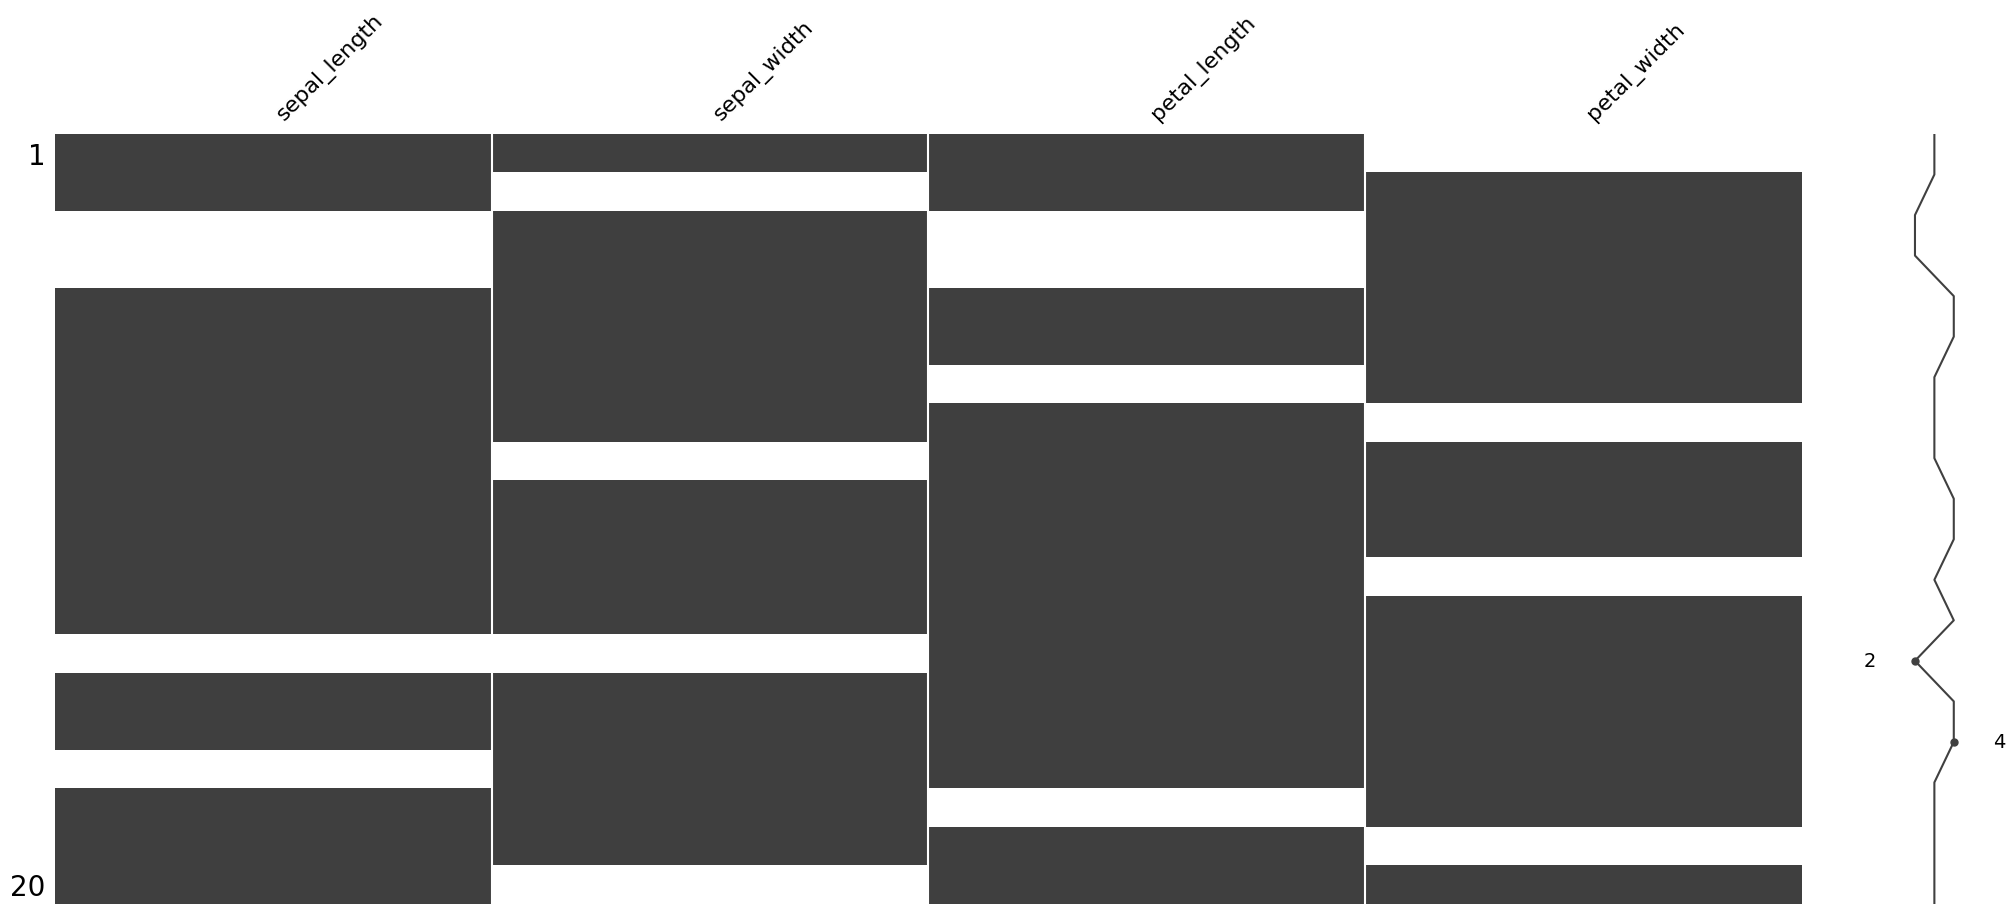

In [16]:
# 결측값(흰색) 패턴을 확인합니다.
# [참고] 여러 열에서 결측값이 있다면 열(변수)의 관계를 확인해야 합니다.
msno.matrix(df = df_na);

### 단순대체
 - mean : 평균
 - median : 중위수
 - most_frequent : 최빈값
 - constant : 상수

> 지원되지 않는 셀 유형입니다. 더블클릭하여 콘텐츠를 검사/수정하세요.

In [17]:
# 관련 라이브러리를 호출합니다.
from sklearn.impute import SimpleImputer

In [18]:
# 결측값을 대체하는 함수를 생성합니다.
# [주의] X 매개변수에 수치형 변수만 데이터프레임 또는 2차원 배열로 지정해야 합니다.
def imputation(imputer, X):
    imputed = imputer.fit_transform(X)
    imputed = pd.DataFrame(data = imputed, columns = X.columns)
    return imputed

In [19]:
# 평균으로 단순대체한 결과를 si에 할당합니다.
si = imputation(
    imputer = SimpleImputer(strategy = 'mean'),
    X = df_na
)

In [20]:
# si에 스타일을 적용한 결과를 확인합니다.
si.style.apply(func = lambda x: style_df, axis = None)

,sepal_length,sepal_width,petal_length,petal_width
0,5.100000,3.500000,1.400000,0.237500
1,4.900000,3.556250,1.400000,0.200000
2,5.106250,3.200000,1.443750,0.200000
3,5.106250,3.100000,1.443750,0.200000
4,5.000000,3.600000,1.400000,0.200000
5,5.400000,3.900000,1.700000,0.400000
6,4.600000,3.400000,1.443750,0.300000
7,5.000000,3.400000,1.500000,0.237500
8,4.400000,3.556250,1.400000,0.200000
9,4.900000,3.100000,1.500000,0.100000


### 다중대체
> mice 라이브러리를 더이상 지원하지 않는 것으로 보임

In [21]:
# 관련 라이브러리를 호출합니다.
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [22]:
# 회귀추정값으로 다중대체한 결과를 mi에 할당합니다.
mi = imputation(
    imputer = IterativeImputer(max_iter = 100, random_state = 0),
    X = df_na
)

In [23]:
# mi에 스타일을 적용한 결과를 확인합니다.
mi.style.apply(func = lambda x: style_df, axis = None)

,sepal_length,sepal_width,petal_length,petal_width
0,5.100000,3.500000,1.400000,0.201523
1,4.900000,3.377686,1.400000,0.200000
2,4.715256,3.200000,1.465086,0.200000
3,4.586302,3.100000,1.480380,0.200000
4,5.000000,3.600000,1.400000,0.200000
5,5.400000,3.900000,1.700000,0.400000
6,4.600000,3.400000,1.449773,0.300000
7,5.000000,3.400000,1.500000,0.215368
8,4.400000,3.057205,1.400000,0.200000
9,4.900000,3.100000,1.500000,0.100000


### KNN 대체

In [24]:
# 관련 라이브러리를 호출합니다.
from sklearn.impute import KNNImputer

In [25]:
# 최근접이웃으로 대체한 결과를 ki에 할당합니다.
ki = imputation(
    imputer = KNNImputer(),
    X = df_na
)

In [26]:
# ki에 스타일을 적용한 결과를 확인합니다.
ki.style.apply(func = lambda x: style_df, axis = None)

,sepal_length,sepal_width,petal_length,petal_width
0,5.100000,3.500000,1.400000,0.240000
1,4.900000,3.200000,1.400000,0.200000
2,4.820000,3.200000,1.380000,0.200000
3,4.820000,3.100000,1.440000,0.200000
4,5.000000,3.600000,1.400000,0.200000
5,5.400000,3.900000,1.700000,0.400000
6,4.600000,3.400000,1.380000,0.300000
7,5.000000,3.400000,1.500000,0.220000
8,4.400000,3.320000,1.400000,0.200000
9,4.900000,3.100000,1.500000,0.100000


### 원본과 대체값 비교

In [27]:
# 변수명을 설정합니다.
varname = 'sepal_length'

In [28]:
# df1의 열이름에서 결측값인 인덱스를 생성합니다.
locs = np.where(df_na[varname].isna())

In [29]:
# origin과 대체값을 가로 방향으로 결합합니다.
merged = pd.concat(
    objs = [df[varname], si[varname], mi[varname], ki[varname]],
    axis = 1
)

In [30]:
# merged의 열이름을 변경합니다.
merged.columns = ['원본', '단순대체', '다중대체', 'KNN대체']

In [31]:
# 결측값인 행만 반환합니다.
merged.loc[locs]

,원본,단순대체,다중대체,KNN대체
2,4.7,5.10625,4.715256,4.82
3,4.6,5.10625,4.586302,4.82
13,4.3,5.10625,4.826948,4.94
16,5.4,5.10625,4.898385,5.12
